In [3]:
!pip install opencv-python
!pip install imutils

import os
import cv2
from google.colab.patches import cv2_imshow
from imutils.video import FPS
from google.colab import files
import torch, torchvision
import os
import cv2
import statistics

In [2]:
%%capture
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt
!pip install torch

In [5]:
yolo_weights_path = '/content/drive/MyDrive/wagi.pt'
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path=yolo_weights_path)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-28 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients
Adding AutoShape... 


In [11]:
main_path = '/content/drive/MyDrive/'

save_path = f'{main_path}processed'

In [13]:
class IdealAnimalCuter():
    def __init__(self, main_path, input_video_name, save_path, yolo_model, bbox_confidence_limit=0.6, number_frames_checked = 1,
                 permissible_distance_bbox_diffrent_frames = 60, number_inactive_bboxes = 20, permissible_distance_bbox_same_frames = 60):
      self.input_video_name = input_video_name
      self.main_path = main_path
      self.input_path = '{}{}'.format(self.main_path, self.input_video_name)
      self.save_path = save_path
      self.video_name = self.input_video_name.split('.')[0]
      self.yolo_model = yolo_model

      # The most important parameters
      self.bbox_confidence_limit = bbox_confidence_limit
      self.number_frames_checked = number_frames_checked
      self.permissible_distance_bbox_diffrent_frames = permissible_distance_bbox_diffrent_frames
      self.number_inactive_bboxes = number_inactive_bboxes
      self.permissible_distance_bbox_same_frames = permissible_distance_bbox_same_frames
      self.DIFF_THRESHOLD_DUPLICATE_BBOX = 10
      self.ACCEPTABLE_NUMBER_TOO_CLOSE_BOXES = 10
      self.MIN_NUMBER_MOVIE_FRAMES = 15

      #variables
      self.current_frame = 0
      self.animal_number = 0
      self.active_animals_dictionary = {}
      self.active_animals_frames_dictionary = {}
      self.distance_bbox_same_frames_dictionary = {}
      self.ideal_animals_frames = {}


    def change_bbox_format_yolo(self, box):
        x = (int(box[0].item()) + int(box[2].item())) // 2
        y = (int(box[1].item()) + int(box[3].item())) // 2
        w = int(box[2].item()) - int(box[0].item())
        h = int(box[3].item()) - int(box[1].item())
        return [x, y, w, h]

    def check_predictions(self, bbox_prediction):
      current_boxes = []

      for *box, confindence, class_id in reversed(bbox_prediction.pred[0]):
        if confindence > self.bbox_confidence_limit and int(class_id) == 0:
          formatted_box = self.change_bbox_format_yolo(box)
          current_boxes.append(formatted_box)

      return current_boxes

    def difference_centers(self, p1, p2):
      if len(p1) == 0 or len(p2) == 0:
          return None
      return (((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2)) ** 0.5

    def delete_bbox_duplicates(self, current_predict_bboxes):
        box_to_remove = [box1 for box1, box2 in zip(current_predict_bboxes, current_predict_bboxes[1:]) if self.difference_centers(box1, box2) <= self.DIFF_THRESHOLD_DUPLICATE_BBOX ]

        if len(box_to_remove) > 0:
            for box in box_to_remove:
              current_predict_bboxes.remove(box)
        return current_predict_bboxes

    def process_box(self, box):
        x1 = int(box[0] - (box[2] / 2))
        y1 = int(box[1] - (box[3] / 2))
        x2 = int(box[0] + (box[2] / 2))
        y2 = int(box[1] + (box[3] / 2))

        return [x1, y1, x2, y2]

    def distance_condition(self, box1, box2):
      return abs(box1[0] - box2[2]) >= self.permissible_distance_bbox_same_frames and abs(box1[2] - box2[0]) >= self.permissible_distance_bbox_same_frames and ((box1[0] <= box2[0] and box1[0] <= box2[2] and box1[2] <= box2[0] and box1[2] <= box2[2]) or (box1[0] >= box2[0] and box1[0] >= box2[2] and box1[2] >= box2[0] and box1[2] >= box2[2]))

    def difference_sides(self, box1, box2):
      if box1 == box2:
        return True
      box1 = self.process_box(box1)
      box2 = self.process_box(box2)

      if self.distance_condition(box1, box2):
        return True
      else:
        return False

    def check_animals_distances_same_frame(self, cur_box, current_predict_bboxes, animal_nr):
      if len(current_predict_bboxes) > 1:
        checking_distance = [self.difference_sides(cur_box, box) for box in current_predict_bboxes]

        if all(checking_distance) == True:
          self.distance_bbox_same_frames_dictionary[animal_nr].append(True)
        else:
          self.distance_bbox_same_frames_dictionary[animal_nr].append(False)

      else:
        self.distance_bbox_same_frames_dictionary[animal_nr].append(True)

    def detect_new_animal(self, cur_box, current_predict_bboxes):
      self.animal_number += 1
      self.active_animals_dictionary[self.animal_number] = [cur_box]
      self.active_animals_frames_dictionary[self.animal_number] = [self.current_frame]
      self.distance_bbox_same_frames_dictionary[self.animal_number] = []
      self.check_animals_distances_same_frame(cur_box, current_predict_bboxes, self.animal_number)

    def detect_exist_animal(self, min_distance, cur_box, current_predict_bboxes):
      animal_nr = list(min_distance.keys())[0]
      self.active_animals_dictionary[animal_nr].append(cur_box)
      self.active_animals_frames_dictionary[animal_nr].append(self.current_frame)
      self.check_animals_distances_same_frame(cur_box, current_predict_bboxes, animal_nr)

    def detect_animal_number(self, cur_box):
      min_distance = {-1: 1000}

      for animal_nr, boxy in self.active_animals_dictionary.items():
        if len(boxy) > self.number_frames_checked:
          distance = statistics.mean([self.difference_centers(cur_box, last_box) for last_box in boxy[-(self.number_frames_checked):]])
        else:
          distance = statistics.mean([self.difference_centers(cur_box, last_box) for last_box in boxy])

        if list(min_distance.values())[0] > distance:
          min_distance = {animal_nr: distance}

      return min_distance


    def fit_box_to_animal(self, current_predict_bboxes):
      for cur_box in current_predict_bboxes:
        if len(self.active_animals_dictionary):
          min_distance = self.detect_animal_number(cur_box)

          if list(min_distance.values())[0] < self.permissible_distance_bbox_diffrent_frames:
            self.detect_exist_animal(min_distance, cur_box, current_predict_bboxes)
          else:
            self.detect_new_animal(cur_box, current_predict_bboxes)

        else:
          self.detect_new_animal(cur_box, current_predict_bboxes)

    def get_active_animals(self, image):
      bbox_prediction = self.yolo_model(image)

      current_predict_bboxes = self.check_predictions(bbox_prediction)
      if len(current_predict_bboxes) > 1:
        current_predict_bboxes = self.delete_bbox_duplicates(current_predict_bboxes)

      if len(current_predict_bboxes)> 0:
        if self.current_frame > 50 and self.current_frame < 60:
          print(self.current_frame)
          for box in current_predict_bboxes:
            x1,y1,x2,y2 = self.process_box(box)
            image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
          cv2_imshow(image)
        self.fit_box_to_animal(current_predict_bboxes)

    def delete_inactive_animals(self):
      animals_to_delete = []
      for animal_nr, frames in self.active_animals_frames_dictionary.items():
        if (self.current_frame - frames[-1]) > self.number_inactive_bboxes:
          animals_to_delete.append(animal_nr)

      if len(animals_to_delete):
        for animal in animals_to_delete:
          self.active_animals_dictionary.pop(animal, "Animals to delete no found")

      return animals_to_delete

    def check_if_it_perfect_animals(self, animals_to_delete):
      for animal in animals_to_delete:
        if self.distance_bbox_same_frames_dictionary[animal].count(False) < self.ACCEPTABLE_NUMBER_TOO_CLOSE_BOXES:
          first_frame = min(self.active_animals_frames_dictionary[animal])
          last_frame = max(self.active_animals_frames_dictionary[animal])
          if (last_frame - first_frame) >= self.MIN_NUMBER_MOVIE_FRAMES:
            self.ideal_animals_frames[animal] = [first_frame, last_frame]

        self.active_animals_frames_dictionary.pop(animal, "Frames to delete no found")

    def process_video(self):
      print(self.input_path)
      print(self.video_name)
      print('{0}/{1}.mp4'.format(self.save_path, self.video_name))
      os.system("ffmpeg -i {0} -r 30 -vf scale=960:540 -an {1}/{2}.mp4 -hide_banner -loglevel error".format(self.input_path, self.save_path, self.video_name))
      self.input_path = '{}/{}.mp4'.format(self.save_path, self.video_name)
      print(self.input_path)

    def get_ideal_animals_frames(self):
        capture = cv2.VideoCapture(self.input_path)

        while True:
            success, image = capture.read()
            if image is None or success is None:
              self.check_if_it_perfect_animals(list(self.active_animals_dictionary.keys()))
              break

            self.get_active_animals(image)
            animals_to_delete = self.delete_inactive_animals()

            if len(animals_to_delete):
              self.check_if_it_perfect_animals(animals_to_delete)

            self.current_frame = self.current_frame + 1

        cv2.destroyAllWindows()

    def create_new_video(self, animal, fps, H, W):
      video_path = '{}/{}_{}.avi'.format(self.save_path, self.video_name, animal)
      video_writer = cv2.VideoWriter_fourcc('M','J','P','G')
      video_file = cv2.VideoWriter(video_path, video_writer, fps, (W, H), True)
      return video_file

    def cut_videos_with_ideal_animals(self):
      capture = cv2.VideoCapture(self.input_path)
      fps = capture.get(cv2.CAP_PROP_FPS)
      active_files = {}

      while True:
        success, image = capture.read()

        if image is None or success is None:
          break

        H, W = image.shape[:2]

        for animal, frames in self.ideal_animals_frames.items():
          if frames[0] == self.current_frame:
            active_files[animal] = self.create_new_video(animal, fps, H, W)

          if frames[1] == self.current_frame:
            active_files[animal].write(image)
            active_files[animal].release()
            active_files.pop(animal, "No found animal file")

        for animal in active_files.keys():
          active_files[animal].write(image)

        self.current_frame = self.current_frame + 1

      cv2.destroyAllWindows()

    def run(self):
      print('Video processing ...')
      self.process_video()
      print('Get ideal animals frames ...')
      self.get_ideal_animals_frames()
      print('Ideal animals frames:', self.ideal_animals_frames)
      self.current_frame = 0
      print('Video cutting ...')
      self.cut_videos_with_ideal_animals()
      print('Done')


Video processing ...
/content/drive/MyDrive/PASCAL/video.mp4
video
/content/drive/MyDrive/PASCAL/processed/video.mp4
/content/drive/MyDrive/PASCAL/processed/video.mp4
Get ideal animals frames ...
51


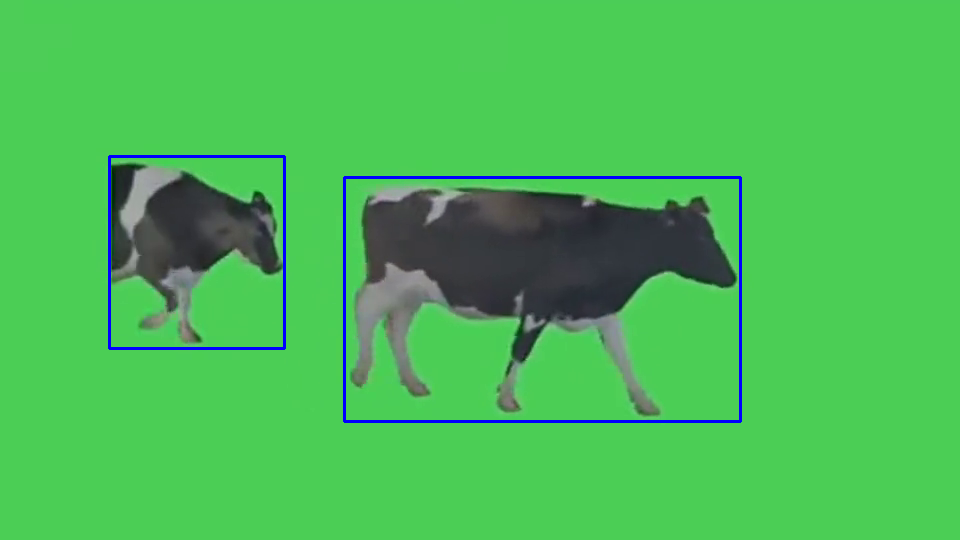

52


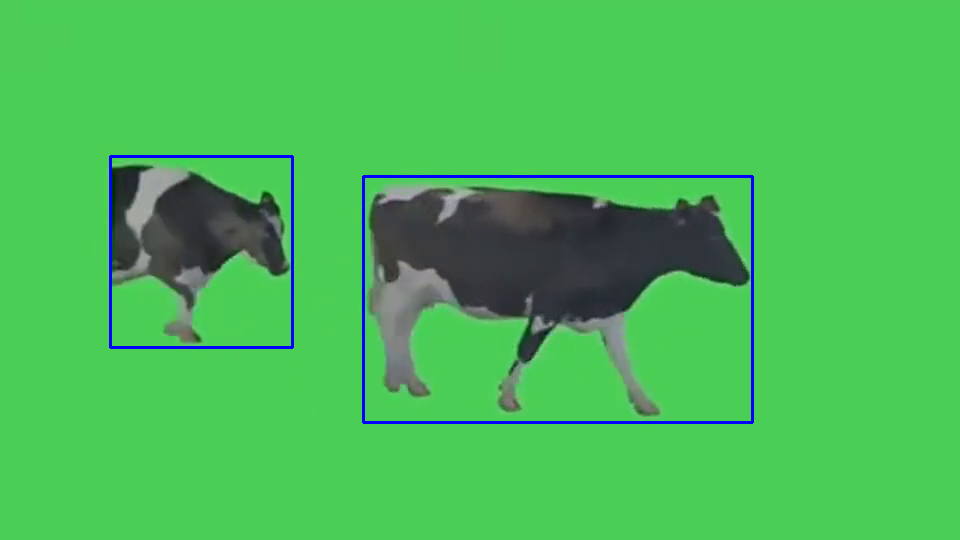

53


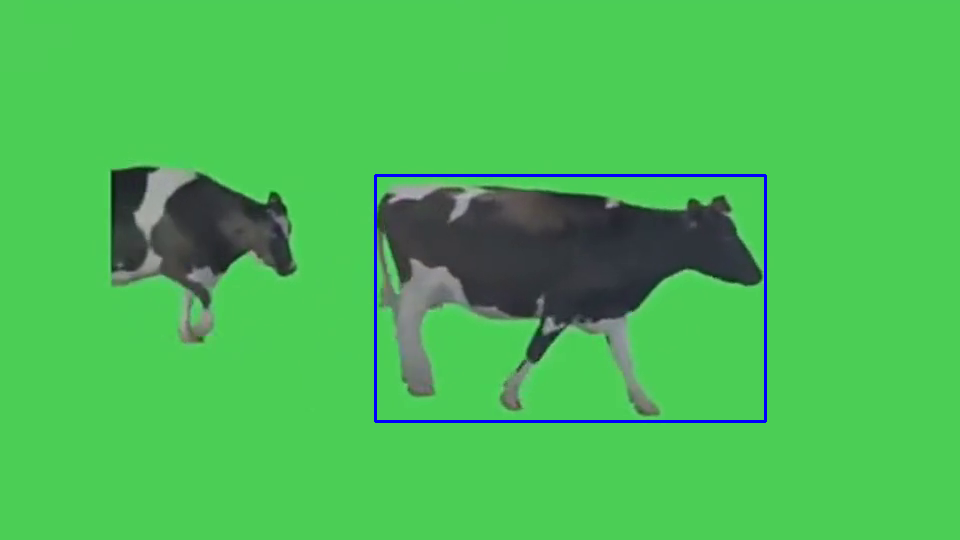

54


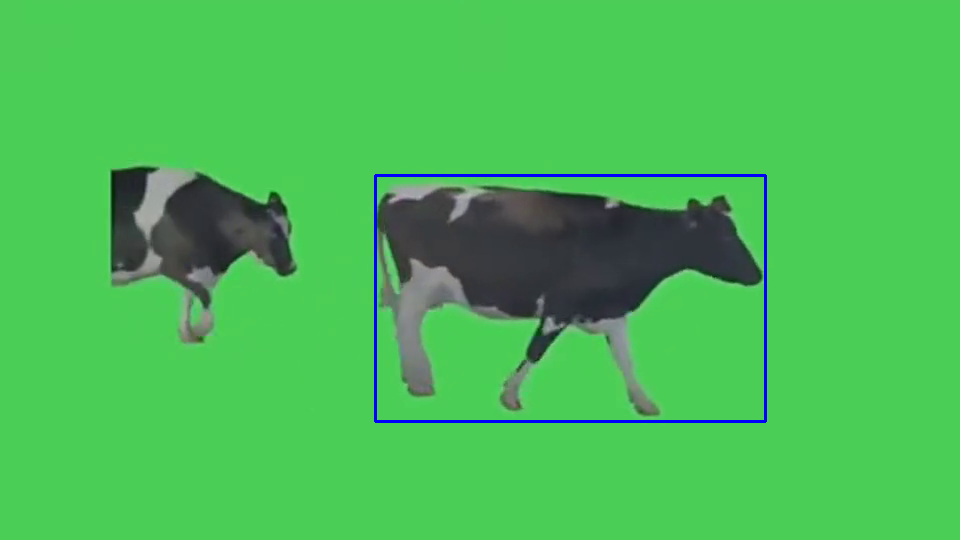

55


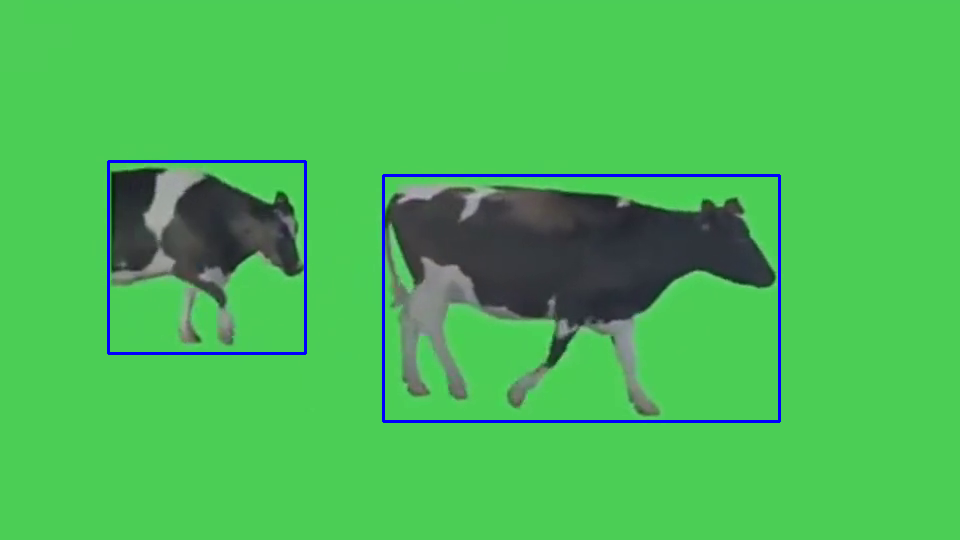

56


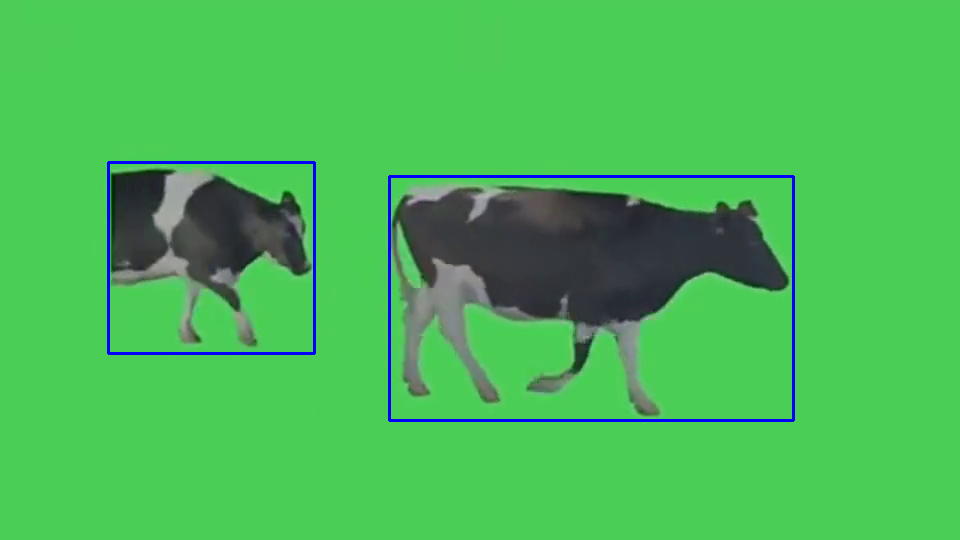

57


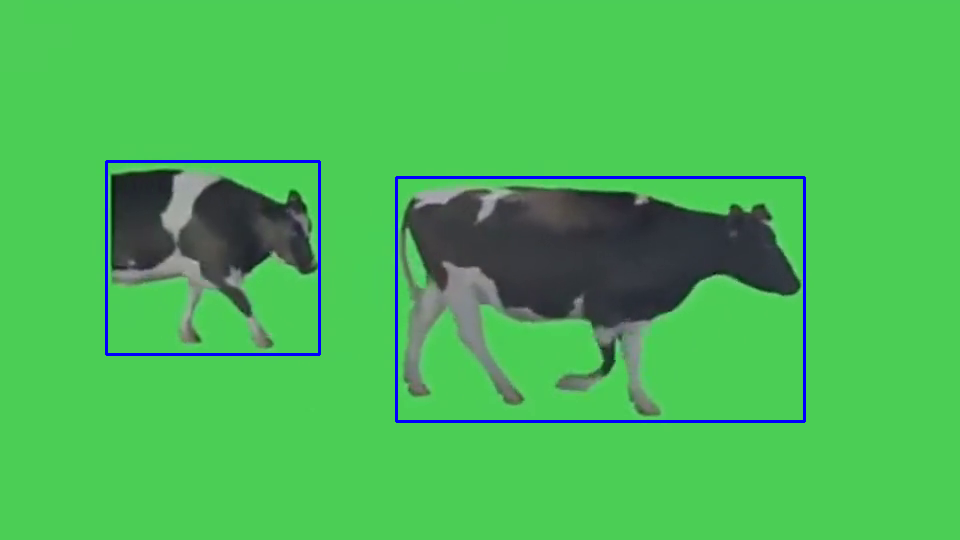

58


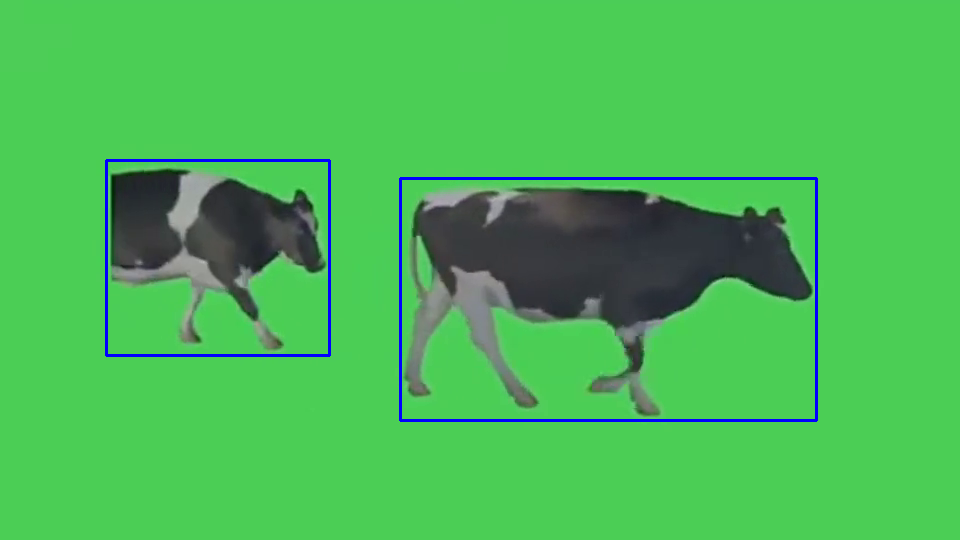

59


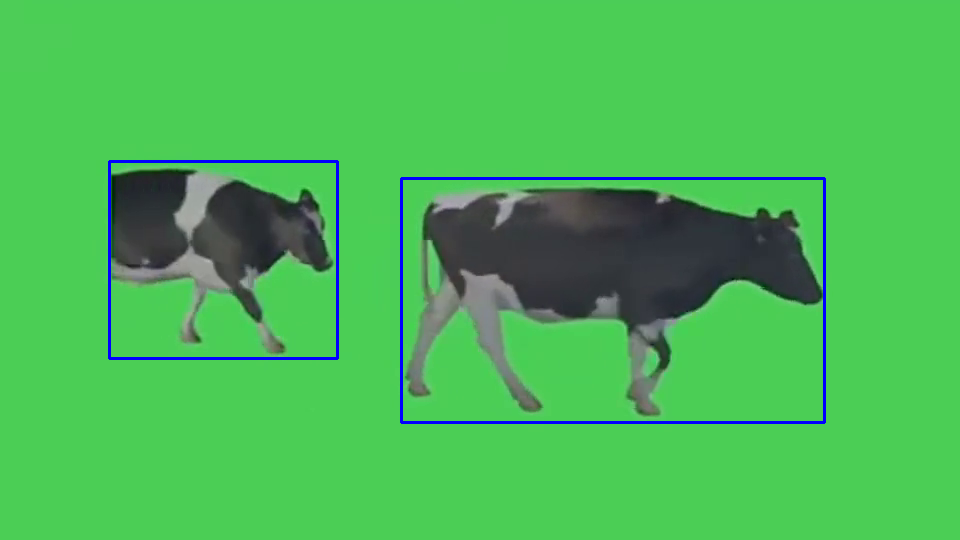

Ideal animals frames: {1: [11, 98], 2: [51, 164], 3: [139, 260]}
Video cutting ...
Done


In [14]:
for movie in os.listdir(main_path):
  if movie.endswith('.mp4'):
    animal_cuter = IdealAnimalCuter(main_path, movie, save_path, yolo_model, permissible_distance_bbox_same_frames = 30)
    animal_cuter.run()